# Import cell


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, NMF, DictionaryLearning
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.colors

import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy import io
import numpy as np
import os
import os.path
from matplotlib import cm
from scipy.signal import savgol_filter as sg
from scipy import interpolate

# Instructions

1. Set global parameters <br>
       a. global_n: An interger. How many components do you want to have? 
       b. global_alp: A list of floats. Which alpha values do you want to try?
       c. save_path/add_in_save: Just where to save the figures etc.
2. Run all cells.

# Global Parameters

In [2]:
save_path = './'        #Where to save figures
global_n = 5           # Number of components in dictionary learning analysis
add_in_save = ''       # Add into the figure save name
global_alp = [1,6,12]  # Alpha values to try

path_to_data = './'

# Automatically generate a folder structure to save results
comp_folder = str(global_n)+'_comp/'
alp_folder = str(global_alp)+'_alp/'

if not os.path.exists(save_path+comp_folder+alp_folder):
    os.makedirs(save_path+comp_folder+alp_folder)

# References

[1]  J. C. Agar, Y. Cao, B. Naul, S. Pandya, S. van der Walt, A. I. Luo, J. T. Maher, N. Balke, S. Jesse,S. V. Kalinin, R. K. Vasudevan,  and L. W. Martin, Advanced Materials 30, 1800701 (2018). <br>
[2]  J. C. Agar, B. Naul, S. Pandya, S. van der Walt, J. Maher, Y. Ren, L.-Q. Chen, S. V. Kalinin, R. K.Vasudevan, Y. Cao, J. S. Bloom,  and L. W. Martin, Nature Communications 10, 4809 (2019)

# Import and Clean Their Data

Import the data with scipy, which provides functions for loading matlab files

In [3]:
# imports the raw band excitation data
imported = {'data': io.matlab.loadmat(path_to_data+'Data.mat'),
            'validation_data': io.matlab.loadmat(path_to_data+'loop_1.mat')}

# extracts the important information from the raw data
raw = {'voltage': imported['data']['Voltagedata_mixed'],
       'piezoresponse': imported['data']['Loopdata_mixed'],
       'amplitude': imported['data']['OutA2_mixed'],
       'phase': imported['data']['OutPhi2_mixed'],
       'resonance': imported['data']['Outw2_mixed'],
       'quality_factor': imported['data']['OutQ2_mixed'],
       'val_piezoresponse': imported['validation_data']['piezo_1'],
       'val_resonance': imported['validation_data']['resonance_loop_1'],
       #'pr_1': imported['data']['OutA1_mixed']*np.sin(np.deg2rad(imported['data']['OutPhi1_mixed'])),
       'pr_1': imported['validation_data']['piezo_1'],
       'res_1': imported['data']['Outw1_mixed'],
       'amp_1': imported['data']['OutA1_mixed'],
       'ph_1': imported['data']['OutPhi1_mixed'],
       'q_1': imported['data']['OutQ1_mixed'],}

The cleaning functions and comments obtained from Agar et. al [1,2] <br>

In [4]:
raw['piezoresponse'].shape

(60, 60, 96)

In [5]:
def range_filter(data, ranges):
    """
    includes only data within a range of values as selected by the user.\n

    Parameters
    ----------
    data : numpy array
        array of loops
    ranges : array
        range of values to include

    Returns
    -------
    data : numpy array
        array of loops
    """
    # checks if data is 3 dimensions
    if data.ndim == 3:

        # manually removes values which are too high or too low
        for i in range(data.shape[0]):

            for j in range(data.shape[1]):

                # finds low and high values
                low = data[i, j] < min(ranges)
                high = data[i, j] > max(ranges)
                outliers = np.where(low + high)

                # removes found values and sets = nan
                data[i, j, outliers] = np.nan
    else:

        raise ValueError('Input data does not have a valid dimension')

    return data


def clean_interpolate(data, fit_type='spline'):
    """
    Function which removes bad data points

    Parameters
    ----------
    data : numpy, float
        data to clean
    fit_type : string  (optional)
        sets the type of fitting to use

    Returns
    -------
    data : numpy, float
        cleaned data
    """

    # sets all non finite values to nan
    data[~np.isfinite(data)] = np.nan
    # function to interpolate missing points
    data = interpolate_missing_points(data, fit_type)
    # reshapes data to a consistent size
    data = data.reshape(-1, data.shape[2])
    return data


def interpolate_missing_points(data, fit_type='spline'):
    """
    Interpolates bad pixels in piezoelectric hysteresis loops.\n
    The interpolation of missing points allows for machine learning operations

    Parameters
    ----------
    data : numpy array
        array of loops
    fit_type : string (optional)
        selection of type of function for interpolation

    Returns
    -------
    data_cleaned : numpy array
        array of loops
    """

    # reshapes the data such that it can run with different data sizes
    if data.ndim == 2:
        data = data.reshape(np.sqrt(data.shape[0]).astype(int),
                            np.sqrt(data.shape[0]).astype(int), -1)
        data = np.expand_dims(data, axis=3)
    elif data.ndim == 3:
        data = np.expand_dims(data, axis=3)

    # creates a vector of the size of the data
    point_values = np.linspace(0, 1, data.shape[2])

    # Loops around the x index
    for i in range(data.shape[0]):

        # Loops around the y index
        for j in range(data.shape[1]):

            # Loops around the number of cycles
            for k in range(data.shape[3]):

                if any(~np.isfinite(data[i, j, :, k])):

                    # selects the index where values are nan
                    ind = np.where(np.isnan(data[i, j, :, k]))

                    # if the first value is 0 copies the second value
                    if 0 in np.asarray(ind):
                        data[i, j, 0, k] = data[i, j, 1, k]

                    # selects the values that are not nan
                    true_ind = np.where(~np.isnan(data[i, j, :, k]))

                    # for a spline fit
                    if fit_type == 'spline':
                        # does spline interpolation
                        spline = interpolate.InterpolatedUnivariateSpline(point_values[true_ind],
                                                                          data[i, j, true_ind, k].squeeze())
                        data[i, j, ind, k] = spline(point_values[ind])

                    # for a linear fit
                    elif fit_type == 'linear':

                        # does linear interpolation
                        data[i, j, :, k] = np.interp(point_values,
                                                     point_values[true_ind],
                                                     data[i, j, true_ind, k].squeeze())

    return data.squeeze()


In [6]:
# These cleaning steps were also performed in [1,2]
range_filter(raw['resonance'], [1300, 1340])          # "Hard limit" replace resonance values outside the specified range with NaN     
range_filter(raw['val_resonance'], [1300, 1340])      # Same for the first cycle resonance
clean_interpolate(raw['resonance'],'linear').reshape(-1, raw['resonance'].shape[2])    #Interpolate those NaNs

array([[1316.56298484, 1316.85098085, 1316.4753691 , ..., 1317.9234046 ,
        1318.10937733, 1318.03857044],
       [1319.31182758, 1319.11098001, 1319.36025077, ..., 1320.27286958,
        1320.16729895, 1320.17534472],
       [1319.29792087, 1319.05178431, 1319.07999963, ..., 1319.37266502,
        1319.58981849, 1319.87632619],
       ...,
       [1327.44357597, 1327.31951814, 1327.33201154, ..., 1327.70510708,
        1327.78603897, 1327.80754424],
       [1327.17790234, 1327.34066654, 1327.21556803, ..., 1327.87324892,
        1327.72284503, 1327.75400904],
       [1326.7496446 , 1326.96006052, 1326.98423162, ..., 1327.18681378,
        1327.33968267, 1327.23022542]])

# Extract and Format 

Extract the data we are interested in (second cycle) and put into a format we are more familiar with.

In [7]:
# extract the second cycle data (amplitude, phase, resonance, and Q)
second_amp = np.reshape(raw['amplitude'],(3600,96))
second_ph = np.reshape(raw['phase'],(3600,96))
second_res = np.reshape(raw['resonance'],(3600,96))
second_q = np.reshape(raw['quality_factor'],(3600,96))

# Extract the provided "optimal rotation angle"
opt_ang = np.reshape(imported['data']['optrotang_mixed'],(3600))

# Resonstrcut the second cycle PR
second_ph = second_ph+np.mean(opt_ang)
second_pr = second_amp*np.cos(np.deg2rad(second_ph))

#Extract voltage data
v_cycle = imported['data']['VoltageDC_mixed'][:,0].squeeze()


In [8]:
# Replace any infinte values in the amplitude/phase curves with NaN. NaNs can be ignored when taking the mean, infs can't.
second_amp[~np.isfinite(second_amp)] = np.nan
second_ph[~np.isfinite(second_ph)] = np.nan

# Get the mean maps for plotting later
sA_mean = np.nanmean(second_amp, axis=1)
sP_mean = np.nanmean(second_ph, axis=1)
sR_mean = np.nanmean(second_res, axis=1)
sQ_mean = np.nanmean(second_q, axis=1)
sPR_mean = np.nanmean(second_pr, axis=1)


### Convert their data to our format, basically a Pandas DataFrame

In [9]:
all_second = np.hstack([second_pr,second_res])       #Here we are interested in the piezoresponse and the resonance
num_vars = 2     # Thats two variables

#We have to account for infinite values (bad fits) in the piezoresponse
x, y = np.where(~np.isfinite(all_second))
all_second[x, y] = 0

#-------------Generate all of the various labels to use in the data frame
times = 96
all_vals = np.repeat('PR', times)
for var in ['Res']:
    varlist = np.repeat(var, times)
    all_vals = np.hstack([all_vals,varlist])

xvals = np.hstack([v_cycle,v_cycle])
chirps = np.tile(np.arange(times),num_vars)
inout = np.tile(np.full(times, 0),num_vars)
plotgroup = np.tile(np.full(times, 0),num_vars)
arrays =[all_vals,chirps,inout,plotgroup,xvals]

cols = pd.MultiIndex.from_tuples(list(zip(*arrays)), names=['Vars', 'ChirpNum','InOut','PlotGroup','xaxis'])
index = pd.Index(np.arange(3600).astype(int),name='Acq')
#---------------

# Create the dataframe
second_data = pd.DataFrame(all_second, columns=cols, index=index)

# Use Kmeans to highlight outliers

### Remove Mean and Scale PR

In [10]:
scale = 3 # Constant to scale PR by such that resonance and PR have the same standard deviation

# For each row of data (i.e. spatial point), remove the mean of the row
second_data['Res'] = second_data['Res'].apply(lambda x: x-x.mean(), axis=1)
second_data['PR'] = second_data['PR'].apply(lambda x: x-x.mean(), axis=1)

#Scale piezoresponse
second_data['PR'] = second_data['PR']*scale*1e4

### Kmeans w/ 8 comp

In [11]:
# Run kmeans
var = ['Res']         # Variable to run
data = second_data    # Data to run
voltages = v_cycle    # x-axis data, i.e. voltages

orig_shape = [60,60]
nclusters = 8
voltages = data[var].columns.get_level_values('xaxis')

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(data[var])
clus_mean_removal = kmeans.labels_.reshape((orig_shape[0], orig_shape[1]))
cent_mean_removal = kmeans.cluster_centers_

In [53]:
second_data[var].shape

(3600, 96)

In [59]:
res_data.shape
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(res_data)
clus_mean_removal = kmeans.labels_.reshape((orig_shape[0], orig_shape[1]))
cent_mean_removal = kmeans.cluster_centers_

In [62]:
orig_shape[1]

60

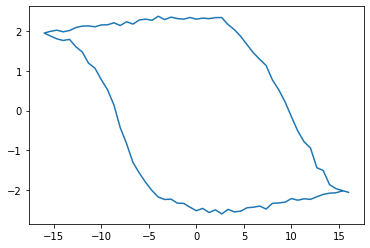

In [37]:
plt.plot(vol,data[1,0:96])

In [63]:
#make a nice color map
my_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:pink','tab:gray']
new_colors = np.asarray(['navy', 'cornflowerblue', 'mediumorchid', 'limegreen', 'cyan', 'gold', 'tomato','black'])
new_colors[[6,0,5,2,7,4,1,3]] = my_colors
my_colors = new_colors
    
cmap = matplotlib.colors.ListedColormap(my_colors)
boundaries = np.arange(len(my_colors)+1)-0.5
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)

Plot Functions - Kmeans

In [13]:
def plot_map(ax, clusters, cmap, norm):
    im = ax.imshow(clusters, cmap=cmap, norm=norm, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    return im
    
def plot_comp(ax, i, centroids, cmap, kwargs_comps={}, kwargs_text={},labelpad=None, topPlot=False, conv=[6,0,4,5,3,1,7,2]):
    voltages = data[var].columns.get_level_values('xaxis')
    #ax.plot(voltages,std_mean[var][1]+std_mean[var][0]*(centroids[i]/1000), label="Cluster " + str(i), color=cmap(i), **kwargs_comps)
    
    #plotdata = (centroids/np.mean(centroids)-1)*100
    plotdata = centroids - np.mean(centroids)
    #plotdata = centroids
    
    #if topPlot:
    #    ax.plot(voltages,((plotdata[i]+second_offsets[var])), label="Cluster " + str(i), color=cmap(i), **kwargs_comps)
    #else:
    #    ax.plot(voltages,((plotdata[i]+second_offsets[var])), label="Cluster " + str(i), color=cmap(i), **kwargs_comps)
    
    j = conv[i]

    if topPlot:
        ax.plot(voltages,((plotdata[j])), label="Cluster " + str(i), color=cmap(j), **kwargs_comps)
    else:
        ax.plot(voltages,((plotdata[j])), label="Cluster " + str(i), color=cmap(j), **kwargs_comps)
    
    half_n = int(nclusters/2)
    
    if i == half_n:
        ax.annotate('Voltage (V)',(-0.45,-0.4),xycoords='axes fraction',**kwargs_text)
    
    plt.xticks(**kwargs_text)
    
    if i != nclusters-1:
        ax.set_yticks([])
    else:
        if not topPlot:
            #ax.set_ylabel('Deviation. (kHz)', **kwargs_text)
            ax.annotate('Res. Deviation (kHz)', (1.5,0.4),xycoords='axes fraction', rotation='vertical', **kwargs_text)
        #    ax.set_ylabel('Res. Dev. (kHz)', **kwargs_text)
        else:
        #    ax.set_ylabel('Resonance (kHz)', **kwargs_text)
            ax.annotate(str(int(np.mean(centroids)))+'+', (0.5,1.05),xycoords='axes fraction', rotation='horizontal', **kwargs_text)
            
        ax.yaxis.set_label_position("right")
        #ax.set_yticklabels('')
        ax.yaxis.tick_right()
        plt.yticks(**kwargs_text)
        
    ax.set_xticks([-10,10])

def plot_all_kmeans(gs, clusters, centroids, kwargs_top_grid={'width_ratios': [0.165,1], 'height_ratios' : [1,0.05],'wspace' : 0.015},
                                          kwargs_comp_grid={'width_ratios': np.repeat(1,nclusters), 'wspace' : 0},
                                          kwargs_text={},
                                          kwargs_large_text={},
                                          labelpad=None, topPlot=False, conv=[6,0,4,5,3,1,7,2]):
    
    fig = plt.gcf()
    
    #gs = fig.add_gridspec(1, 2, **kwargs_top_grid)
    top_level_gs = gs.subgridspec(2, 2, **kwargs_top_grid)
    gs_left = top_level_gs[0,1].subgridspec(1, nclusters, **kwargs_comp_grid)
    
    ax = fig.add_subplot(top_level_gs[0])
    im = plot_map(ax, clusters, cmap, norm)
    
    if topPlot:
        ax.annotate('a.',(-0.22,0.9),xycoords='axes fraction',**kwargs_large_text)
    else:
        ax.annotate('b.',(-0.22,0.9),xycoords='axes fraction',**kwargs_large_text)
    
    ymin_list = []
    ymax_list = []
    ax_list = []
        
    for i in range(nclusters):
        
        ax = fig.add_subplot(gs_left[i])
        plot_comp(ax, i, centroids, cmap, labelpad=labelpad, topPlot=topPlot, kwargs_text=kwargs_text, conv=conv)
        
        if topPlot:
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_xticklabels('')
        
        ymin, ymax = ax.get_ylim()
        ymin_list.append(ymin)
        ymax_list.append(ymax)
        ax_list.append(ax)
        #plt.ylim((1.315e6,1.331e6))
        #plt.title("Cluster" + str(i))
        #plt.legend()#bbox_to_anchor=(1.4,1))
    
    for ax in ax_list:
        yrange = np.abs(min(ymin_list)-max(ymax_list))
        incr_range = yrange*0.08    
        if topPlot:
            ax.set_ylim([min(ymin_list)-incr_range,max(ymax_list)+incr_range])
        else:
            ax.set_ylim([-2.5,2.5])
            #ax.set_ylim([min(ymin_list)-incr_range,max(ymax_list)+incr_range])
        
    #if not topPlot:
    #    ax = fig.add_subplot(top_level_gs[1,0])
    #    cb = plt.colorbar(im, cax=ax, orientation='horizontal',ticks=np.arange(global_n))
        #cb.set_label(label='Cluster',**kwargs_text)
    #    cb.ax.tick_params(labelsize=kwargs_text['fontsize'])

def plot_mean_maps(gs, data, kwargs_top_grid={'width_ratios': [1,1,1,1], 'height_ratios' : [1,0.05], 'hspace':0.02 },kwargs_large_text={}):
    
    fig = plt.gcf()
    
    top_level_gs = gs.subgridspec(2, 4, **kwargs_top_grid)
    
    sub_labels = ['c.','d','e','f']
    
    for i, var in enumerate(data):
        ax = fig.add_subplot(top_level_gs[0,i])
        cax = fig.add_subplot(top_level_gs[1,i])
                
        #if var is 'Amplitude (a.u.)':
        if i == 0:
            plot_data = data[var]*1e6
        #elif var is r'Phase ($^\circ$)':
        elif i == 1:
            plot_data = data[var] - np.min(data[var])
        #elif var is 'Q (a.u.)':
        elif i == 2:
            plot_data = data[var]
        #elif var is 'Resonance (kHz)':
        elif i == 3:
            plot_data = data[var]
        
        im = ax.imshow(np.reshape(plot_data,(60,60)), cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i == 0 :
            ax.annotate(sub_labels[i],(-0.13,0.9),xycoords='axes fraction',**kwargs_large_text)
        
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
        #if i == 0:
        #    cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
        #    cbar.set_ticks([30,50,70,90])
        #    cbar.set_ticklabels([30,50,70,90])
        #elif i == 1:
        #    cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
        #    cbar.ax.set_xticks([0,50,100])
        #    cbar.ax.set_xticklabels([0,50,100])
        #elif i == 2:
        #    cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
        #    cbar.set_ticks([175,200,225])
        #    cbar.set_ticklabels([175,200,225])
        if i == 3:
            #cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
            cbar.set_ticks([1315,1325])
            cbar.set_ticklabels([1315,1325])



This kmeans analysis will be the same as in Fig. 1c. It is re-run here to confirm consistency and show we can remove the identified points. <br>
Note: the order of the components is likely different

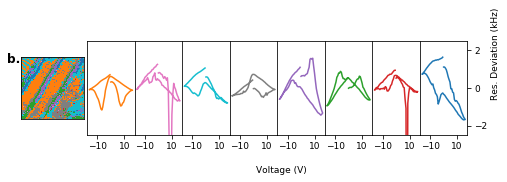

In [14]:
fig = plt.figure(figsize=(8,2))
gs = fig.add_gridspec(1, 1)

#plot_all_kmeans(gs_kmeans[0,:], clus_wo_mean_removal, cent_wo_mean_removal, labelpad=6, kwargs_text={'fontsize' : 9}, topPlot=True, kwargs_large_text={'fontsize':12,'color':'k','fontweight':'bold', 'color':'k'}, conv=[6,0,5,2,7,4,1,3])
plot_all_kmeans(gs[0], clus_mean_removal, cent_mean_removal, labelpad=100, kwargs_text={'fontsize' : 9}, kwargs_large_text={'fontsize':12,'color':'k','fontweight':'bold', 'color':'k'}, conv=[0,1,2,3,4,5,6,7])

#plot_mean_maps(gs[1], {r'Amplitude ($\mu$V)':sA_mean,r'Phase ($^\circ$)':sP_mean,'Q (a.u.)':sQ_mean,'Resonance (kHz)':sR_mean}, kwargs_large_text={'fontsize':12,'color':'k','fontweight':'bold'})

### Pick behaviors that are "bad" and should be removed

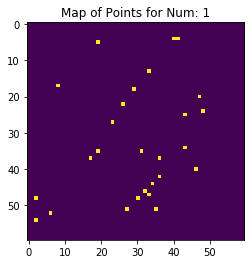

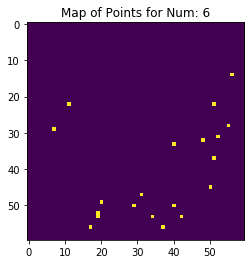

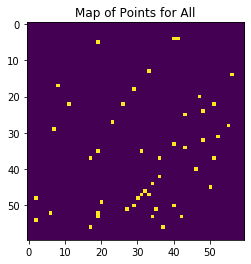

In [15]:
bad_list = [1,6]   # Chose "bad" behaviors from above, where 0 represents the left most behavior and 7 the right most.

remove = np.full((60,60),False)   # Initital "points to remove" flags

# For each identified bad behavior
for num in bad_list:

    # Find the points with said bad behavior
    bad_temp = clus_mean_removal == num
    
    # Plot them over the sample area for convience
    plt.figure()
    plt.imshow(bad_temp)
    
    plt.title('Map of Points for Num: '+str(num),)
    
    # Add points to the list of points to remove
    remove = np.logical_or(remove,bad_temp)

#plot all points over the sample area we are removing
plt.figure()
plt.imshow(remove)
plt.title('Map of Points for All')

flags = np.reshape(remove,(3600))

### Run a final kmeans analysis

We use an initial kmeans analysis to "seed" the dictionary learning, basically provides a first guess for the optimized

In [33]:
pie_data = np.load('pizoresponse.npy')
res_data = np.load('resonance.npy')
vol = np.load('voltage.npy')

In [38]:
pie_data = pie_data.reshape(3600,96)

In [40]:
new_data = np.hstack([pie_data,res_data])

In [41]:
new_data.shape

(3600, 192)

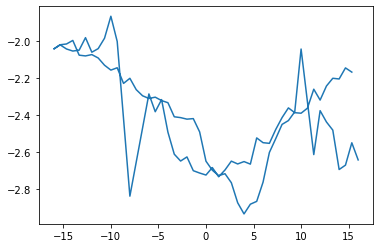

In [43]:
plt.plot(vol,new_data[0,96:192])

In [16]:
stack_vars = ['PR','Res']
data_list = ['PR','Res']
data = all_second
voltages = v_cycle

orig_shape = [60,60]
nclusters = global_n

stacked_dataset = second_data

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(stacked_dataset.values[~flags,:])
clusters_2nd = kmeans.labels_
centroids_2nd = kmeans.cluster_centers_

In [65]:
stacked_dataset.values[~flags,:].shape

(3553, 192)

In [78]:
kmeans = KMeans(n_clusters=16, random_state=0).fit(new_data)
clusters_2nd = kmeans.labels_
centroids_2nd = kmeans.cluster_centers_

In [79]:
centroids_2nd.shape

(16, 192)

# Run Dictionary Learning

In [32]:
stacked_dataset.shape

(3600, 192)

In [17]:
# Lists to save all of the components/maps
comps = []
maps = []

voltages = v_cycle              #Voltage values
stacked_dataset = second_data  #The data to analyze

# For each alpah value listed above
for alp in global_alp:

    orig_shape = [60,60]       # Don't forget this is a 60,x60 grid
    sparsity = alp             # Alpha value for this iteration
    iterations = 10000         # Max number of iterations
    num_components = global_n  # Number of components to find

    dataset_analysis = stacked_dataset.values[~flags,:]    # Remove the above "bad" points from consideration

    #### Reformat the kmeans results to use as the initial guess for Dictionary learning
    labels = clusters_2nd
    comp_init = np.zeros_like(centroids_2nd)
    lm_init = np.zeros((len(labels),num_components))
    for i in range(num_components):
        u = np.zeros_like(labels)
        u[labels==i] = 1
        lm_init[:,i] = u
        comp_init[i] = centroids_2nd[i]
        
    # Set up dictionary learning model
    model = DictionaryLearning(n_components=num_components, code_init=lm_init, dict_init = comp_init, n_jobs=-1, max_iter=iterations, transform_algorithm='lasso_lars', alpha=sparsity, fit_algorithm='cd',positive_code=True, tol=1e-9)
    
    # Fit and get weight maps/ components
    DL_loading_maps = model.fit_transform(dataset_analysis)
    DL_components = model.components_

    #Normalize the Maps and components. For each component, divide the maps by the max value and multiply the components by this same value 
    pr_len = int(DL_components.shape[1]/2)
    DL_components[:,:pr_len] = DL_components[:,:pr_len]/10
    for n in np.arange(0,num_components):
        map_data = DL_loading_maps[:,n]
        max_val = np.max(map_data)
        norm_map = map_data/max_val

        norm_comp = DL_components[n,:]*max_val

        DL_loading_maps[:,n] = norm_map
        DL_components[n,:] = norm_comp
        
    # Reshape maps into the original 3600 points
    # Basically undo the removal of those points, 
    # placing infs where the removed points were
    temp = np.full((3600,global_n),np.inf)
    temp[~flags,:] = DL_loading_maps
    DL_loading_maps = temp

    # Add the results to the lists
    comps.append(DL_components)
    maps.append(DL_loading_maps)

In [80]:
comp_init = np.zeros_like(centroids_2nd)
lm_init = np.zeros((len(clusters_2nd),16))

In [81]:
lm_init.shape

(3600, 16)

In [82]:
comp_init.shape

(16, 192)

In [84]:
model = DictionaryLearning(n_components=16, code_init=lm_init, dict_init = comp_init, n_jobs=-1, max_iter=iterations, transform_algorithm='lasso_lars', alpha=sparsity, fit_algorithm='cd',positive_code=True, tol=1e-9)
    
# Fit and get weight maps/ components
DL_loading_maps = model.fit_transform(new_data)
DL_components = model.components_

#Normalize the Maps and components. For each component, divide the maps by the max value and multiply the components by this same value 
pr_len = int(DL_components.shape[1]/2)
DL_components[:,:pr_len] = DL_components[:,:pr_len]/10
for n in np.arange(0,num_components):
    map_data = DL_loading_maps[:,n]
    max_val = np.max(map_data)
    norm_map = map_data/max_val

    norm_comp = DL_components[n,:]*max_val

    DL_loading_maps[:,n] = norm_map
    DL_components[n,:] = norm_comp

# # Reshape maps into the original 3600 points
# # Basically undo the removal of those points, 
# # placing infs where the removed points were
# temp = np.full((3600,global_n),np.inf)
# temp[~flags,:] = DL_loading_maps
# DL_loading_maps = temp

# # Add the results to the lists
# comps.append(DL_components)
# maps.append(DL_loading_maps)

In [85]:
embedding = model.transform(new_data)

In [86]:
embedding.shape

(3600, 16)

In [87]:
DL_components.shape

(16, 192)

In [24]:
from tqdm import tqdm

In [92]:
vol1=np.concatenate([vol,vol])

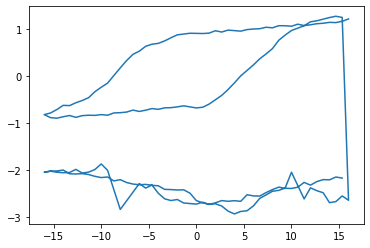

In [94]:
plt.plot(vol1,new_data[0])

In [105]:
out = model.transform(new_data)

In [107]:
out = np.dot(out,model.components_)

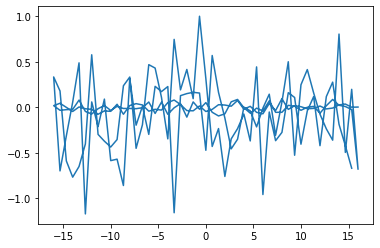

In [110]:
plt.plot(vol1,out[0])

In [95]:
Gan = generator(model,new_data,np.zeros((60,60)))

In [103]:
from scipy import ndimage
from os.path import join as pjoin

In [104]:
Gan.generator_images(folder, graph_layout=[16,4])

100%|██████████| 200/200 [09:47<00:00,  2.94s/it]


In [97]:
import os
folder = make_folder('movie_')

In [28]:
printing = {'PNG':True,
            'EPS':False, 
           'dpi': 300}
class generator:
    def __init__(self, 
                 model,
                 scaled_data,
                 image, 
                 channels = None,
                 color_map = 'viridis'):
        self.model = model
        self.image = image
        # defines the colorlist
        self.cmap = plt.get_cmap(color_map)
        
        if isinstance(model, type(DictionaryLearning())): 
            def predictor(values): 
                return np.dot(values, model.components_)
            self.predict = predictor
            self.vector_length = scaled_data.shape[1]
            self.embeddings = model.transform(scaled_data)
        elif isinstance(model,type(model_builder(np.atleast_3d(scaled_data)))):
            def predictor(values): 
                return model.decoder_model.predict(np.atleast_2d(values))
            self.embeddings = model.encoder_model.predict(np.atleast_3d(scaled_data))
            self.predict = predictor
            self.vector_length = scaled_data.shape[1]
        else:
            raise Exception('The model is not an included model type '.format(dictonary_model))
            
        if channels == None:
            self.channels = range(self.embeddings.shape[1])
        else: 
            self.channels = channels
    def generator_images(self, 
                         folder, 
                        ranges = None,
                         number_of_loops = 200, 
                        averaging_number = 100,
                        graph_layout = [3,3], 
                        y_lim = [-2,2],
                        xlabel = '',
                        ylabel = '',
                        xvalues = None
                        ):
        folder = make_folder(folder)
        for i in tqdm(range(number_of_loops)):
            # builds the figure
            #fig, ax = plt.subplots(graph_layout[0] // graph_layout[1] + (graph_layout[0] % graph_layout[1] > 0), graph_layout[1],
            #                       figsize=(3 * graph_layout[1], 3 * (graph_layout[0] // graph_layout[1] + (graph_layout[0] % graph_layout[1] > 0))))
            fig, ax = layout_fig(graph_layout[0], mod=graph_layout[1])
            ax = ax.reshape(-1)
            # loops around all of the embeddings
            for j, channel  in enumerate(self.channels):
                # checks if the value is None and if so skips tp next iteration
                if i is None:
                    continue
                if xvalues is None:
                    xvalues = range(self.vector_length)
                if ranges is None: 
                    ranges =  np.stack((np.min(self.embeddings,axis=0),
                              np.max(self.embeddings,axis=0)), axis=1)
                # linear space values for the embeddings
                value = np.linspace(ranges[channel][0], ranges[channel][1], 
                                    number_of_loops)
                # finds the nearest point to the value and then takes the average
                # average number of points based on the averaging number
                idx = find_nearest(
                    self.embeddings[:,channel], 
                    value[i], 
                    averaging_number)
                # computes the mean of the selected index
                gen_value = np.mean(self.embeddings[idx], axis=0)
                # specifically updates the value of the embedding to visualize based on the
                # linear spaced vector
                gen_value[channel] = value[i]
                # generates the loop based on the model
                generated = self.predict(gen_value).squeeze()
                # plots the graph
                ax[j].plot(xvalues, generated, color=self.cmap((i + 1) / number_of_loops))
                # formats the graph
                ax[j].set_ylim(y_lim[0],y_lim[1])
                ax[j].set_yticklabels('')
                ax[j].set_xlabel(xlabel)
                # gets the position of the axis on the figure
                pos = ax[j].get_position()
                # plots and formats the binary cluster map
                axes_in = plt.axes([pos.x0 - .03, pos.y0, .06 , .06])
                ## rotates the figure
                #if plot_format['rotation']:
                #    imageb, scalefactor = rotate_and_crop(embeddings[:, j].reshape(image.shape),
                #                                          angle=plot_format['angle'], frac_rm=plot_format['frac_rm'])
                #else:
                #    scalefactor = 1
                #    imageb = encode_small[:, j].reshape(60, 60)
                # plots the imagemap and formats
                image_,angle_ = rotate_and_crop(self.embeddings[:, channel].reshape(self.image.shape[0:2]))
                axes_in.imshow(image_, clim=ranges[channel])
                axes_in.set_yticklabels('')
                axes_in.set_xticklabels('')
            ax[0].set_ylabel(ylabel)
            savefig(pjoin(folder, f'{i:04d}_maps'), printing)
            plt.close(fig)

In [25]:
def rotate_and_crop(image_, angle=60.46, frac_rm=0.17765042979942694):
    """
    Function which rotates and crops the images

    Parameters
    ----------
    image_ : array
        image array to plot
    angle  : float, optional
        angle to rotate the image by
    frac_rm  : float, optional
        sets the fraction of the image to remove

    Returns
    ----------
    crop_image : array
        image which is rotated and cropped
    scale_factor : float
        scaling factor for the image following rotation
    """
    # makes a copy of the image
    image = np.copy(image_)
    # replaces all points with the minimum value
    image[~np.isfinite(image)] = np.nanmin(image)
    # rotates the image
    rot_topo = ndimage.interpolation.rotate(
        image, 90-angle, cval=np.nanmin(image))
    # crops the image
    pix_rem = int(rot_topo.shape[0]*frac_rm)
    crop_image = rot_topo[pix_rem:rot_topo.shape[0] -
                          pix_rem, pix_rem:rot_topo.shape[0]-pix_rem]
    # returns the scale factor for the new image size
    scale_factor = (np.cos(np.deg2rad(angle)) +
                    np.cos(np.deg2rad(90-angle)))*(1-frac_rm)

    return crop_image, scale_factor

In [26]:
def layout_fig(graph, mod=None):

    if mod is None:
        # Selects the number of columns to have in the graph
        if graph < 3:
            mod = 2
        elif graph < 5:
            mod = 3
        elif graph < 10:
            mod = 4
        elif graph < 17:
            mod = 5
        elif graph < 26:
            mod = 6
        elif graph < 37:
            mod = 7
            
 #       mod = graph//2

    # builds the figure based on the number of graphs and selected number of columns
    fig, axes = plt.subplots(graph // mod + (graph % mod > 0), mod,
                             figsize=(3 * mod, 3 * (graph // mod + (graph % mod > 0))))

    # deletes extra unneeded axes
    axes = axes.reshape(-1)
    for i in range(axes.shape[0]):
        if i + 1 > graph:
            fig.delaxes(axes[i])

    return (fig, axes)

In [27]:
def find_nearest(array, value, averaging_number):
    """
    returns the indices nearest to a value in an image

    Parameters
    ----------
    array : float, array
        image to find the index closest to a value
    value : float
        value to find points near
    averaging_number : int
        number of points to find

    """
    idx = (np.abs(array-value)).argsort()[0:averaging_number]
    return idx

In [96]:
def make_folder(folder, **kwargs):
    """
    Function that makes new folders
    Parameters
    ----------'
    folder : string
        folder where to save
    Returns
    -------
    folder : string
        folder where to save
    """

    # Makes folder
    os.makedirs(folder, exist_ok=True)

    return (folder)

In [101]:
def savefig(filename, printing):
    """
    Saves figure
    Parameters
    ----------
    filename : str
        path to save file
    printing : dictionary
        contains information for printing
        'dpi': int
            resolution of exported image
        print_EPS : bool
            selects if export the EPS
        print_PNG : bool
            selects if print the PNG
    """

    # Saves figures at EPS
    if printing['EPS']:
        plt.savefig(filename + '.eps', format='eps',
                    dpi=printing['dpi'], bbox_inches='tight')

    # Saves figures as PNG
    if printing['PNG']:
        plt.savefig(filename + '.png', format='png',
                    dpi=printing['dpi'], bbox_inches='tight')

### Plot functions

In [17]:
def plot_map(ax, mapdata, c='virids', norm=None,kwargs_maps={}):
    
    if norm is None:
        im = ax.imshow(np.reshape(mapdata,(60,60)), cmap=c, interpolation='none', vmin=0, vmax=1, **kwargs_maps)
    else:
        im = ax.imshow(np.reshape(mapdata,(60,60)), cmap=c, norm=norm, interpolation='none', vmin=0, vmax=1, **kwargs_maps)
    ax.set_xticks([])
    ax.set_yticks([])
    return im
    
def plot_comp(ax, comp_data, var, kwargs_comps={}, kwargs_text={},labelpad=None):
    voltages = v_cycle
    
    shape = comp_data.shape
    
    if var is 'PR':
        ax.plot(voltages,((comp_data[:int(shape[0]/2)]/(scale))), label="Cluster " + str(i),**kwargs_comps)
    else:
        ax.plot(voltages,((comp_data[int(shape[0]/2):])), label="Cluster " + str(i),**kwargs_comps)

In [18]:
grid_spec = np.full((global_n+1),0,dtype=float)
grid_spec[:global_n] = 1
grid_spec[global_n] = 0.075

def plot_dict_learn(gs, all_maps, all_comps, kwargs_top_grid={'height_ratios' : [1,1.75], 'hspace' : 0.01},
                                             kwargs_maps_grid={'width_ratios' : grid_spec, 'wspace' : 0.15},
                                             kwargs_comps_grid={'width_ratios' : grid_spec,'wspace' : 0.15, 'hspace' : 0}, cscale='viridis',
                                             kwargs_cbar_grid={'height_ratios' : [0.0001,2,0.0001]},
                                             kwargs_large_text={'fontsize':12,'fontweight':'bold'},
                                             kwargs_comps={},letter='a.',reorder=[0,3,2,1,5,3]):
    
    fig = plt.gcf()
    
    #gs = fig.add_gridspec(1, 2, **kwargs_top_grid)
    top_level_gs = gs.subgridspec(2, 1, **kwargs_top_grid)
    gs_maps = top_level_gs[0].subgridspec(1, global_n+1, **kwargs_maps_grid)
    gs_comps = top_level_gs[1].subgridspec(2,global_n+1, **kwargs_comps_grid)
    
    pr_ax_list = []
    pr_ymin_list = []
    pr_ymax_list = []
    
    res_ax_list = []
    res_ymin_list = []
    res_ymax_list = []
    
    #if global_n == 4:
    #    reorder = [0,3,2,1]
    #elif global_n == 5:
    #    reorder = [0,1,2,3,4]
    #elif global_n == 6:
    #    reorder = [0,3,2,1,5,4]
    
    for j in range(global_n):
    
        i = reorder[j]
    
        ax_map = fig.add_subplot(gs_maps[j])
        im = plot_map(ax_map, all_maps[:,i], c=cscale)

        ax_pr = fig.add_subplot(gs_comps[0,j])
        plot_comp(ax_pr, all_comps[i,:], var='PR', kwargs_comps=kwargs_comps)
        ax_pr.yaxis.set_label_position("right")
        ax_pr.yaxis.tick_right()
        ax_pr.annotate(r'$N_{}$'.format(j+1),(0.1,0.8),xycoords='axes fraction', color='k', fontsize=10)
        
        ax_res = fig.add_subplot(gs_comps[1,j])
        plot_comp(ax_res, all_comps[i,:], var='Res', kwargs_comps=kwargs_comps)
        ax_res.yaxis.set_label_position("right")
        ax_res.yaxis.tick_right()
        
        ymin, ymax = ax_pr.get_ylim()
        pr_ymin_list.append(ymin)
        pr_ymax_list.append(ymax)
        pr_ax_list.append(ax_pr)
        
        ymin, ymax = ax_res.get_ylim()
        res_ymin_list.append(ymin)
        res_ymax_list.append(ymax)
        res_ax_list.append(ax_res)

        ax_pr.set_xticklabels('')
        ax_res.set_xlabel('Voltage (V)')
        
        if j == global_n-1:
            #ax_res.set_ylabel('Res. Dev (kHz)')
            #ax_pr.set_ylabel('PR (mV)')
            ax_res.annotate(r'$\Delta \omega$ (kHz)',(1.4,0.25),rotation='vertical',xycoords='axes fraction', color='k',)
            ax_pr.annotate(r'$\Delta PR$ (mV)',(1.4,0.3),rotation='vertical',xycoords='axes fraction', color='k')
        else:
            ax_res.set_yticklabels('')
            ax_pr.set_yticklabels('')

        letters = [['f','g','h'],['i','j','k']]
        
        if j == 0:
            ax_map.annotate(letter,(-0.2,0.85),xycoords='axes fraction', color='k', **kwargs_large_text)
        #ax_pr.annotate(letters[i][1],(0.05,0.8),xycoords='axes fraction', **kwargs_large_text)
        #ax_res.annotate(letters[i][2],(0.05,0.8),xycoords='axes fraction', **kwargs_large_text)

    
    gs_cbar = gs_maps[global_n].subgridspec(3, 1, **kwargs_cbar_grid)
    ax_c = fig.add_subplot(gs_cbar[1])
    plt.colorbar(im, cax=ax_c, orientation='vertical')
    #ax_c.yaxis.set_ticks_position('left')
    
    for ax in pr_ax_list:
        yrange = np.abs(min(pr_ymin_list)-max(pr_ymax_list))
        incr_range = yrange*0.08    
        ax.set_ylim([min(pr_ymin_list)-incr_range,max(pr_ymax_list)+incr_range])
        
    for ax in res_ax_list:
        yrange = np.abs(min(res_ymin_list)-max(res_ymax_list))
        incr_range = yrange*0.08    
        ax.set_ylim([min(res_ymin_list)-incr_range,max(res_ymax_list)+incr_range])
        #ax.set_ylim([-2.5,2.5])


### Plot all the results

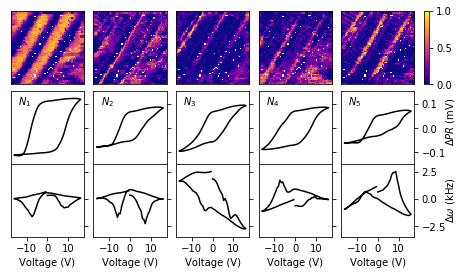

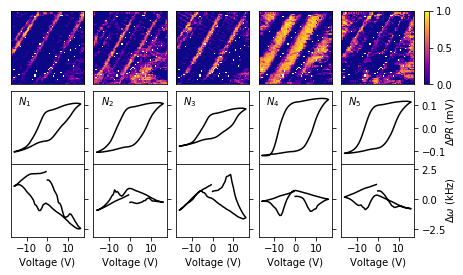

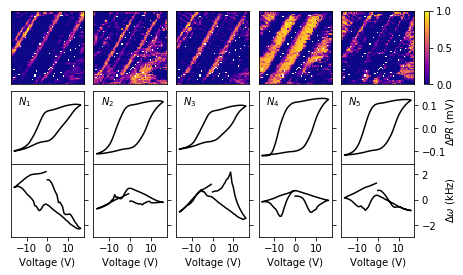

In [19]:
# First, plot the individual results (i.e. plot the analysis for each alpha value)

# Note: the plotter, plot_dict_learn, has a parameter 'reorder'. 
# This simply changes the order in which the components are plotted, as the order in which they are derived is random. 
# A default value would simply be [0,1,2,3,etc.]
# Below are the values we used for the various analysis to ensure that similar behaviors lined up

#5 comp
if global_n == 5:
    reord_a = [1,4,0,2,3]
    reord_b = [0,4,3,1,2]

#6 comp
if global_n == 6:
    reord_a = [5,1,2,0,4,3]
    reord_b = [1,5,2,0,4,3]

#7 comp
if global_n == 7:
    reord_a = [3,0,4,5,2,1,6]
    reord_b = [3,0,4,5,2,1,6]

# for each selected alpha
for i, alp in enumerate(global_alp):

    fig = plt.figure(figsize=(1.5*global_n,4.25))
    gs = fig.add_gridspec(1, 1, wspace=0.05)
    #plot_kmeans(gs[0], np.reshape(clusters_2nd,(3600)), centroids_2nd, kwargs_comps={'linestyle' : '-'}, colors=my_colors)
    
    if i == 0:
        plot_dict_learn(gs[0], maps[i], comps[i], kwargs_comps={'color' : 'k', 'linestyle' : '-'}, cscale='plasma',letter='',reorder=reord_a)
    elif i == 1:
        plot_dict_learn(gs[0], maps[i], comps[i], kwargs_comps={'color' : 'k', 'linestyle' : '-'}, cscale='plasma',letter='',reorder=reord_b)
    elif i == 2:
        plot_dict_learn(gs[0], maps[i], comps[i], kwargs_comps={'color' : 'k', 'linestyle' : '-'}, cscale='plasma',letter='',reorder=reord_b)
    
    fig.tight_layout()
    
    fig.savefig(save_path+comp_folder+alp_folder+'dict_vert_second_alp'+str(alp)+'_'+str(global_n)+'comp'+'.eps', format='eps', dpi=500)
    fig.savefig(save_path+comp_folder+alp_folder+'dict_vert_second_alp'+str(alp)+'_'+str(global_n)+'comp'+'.png', format='png', dpi=500)

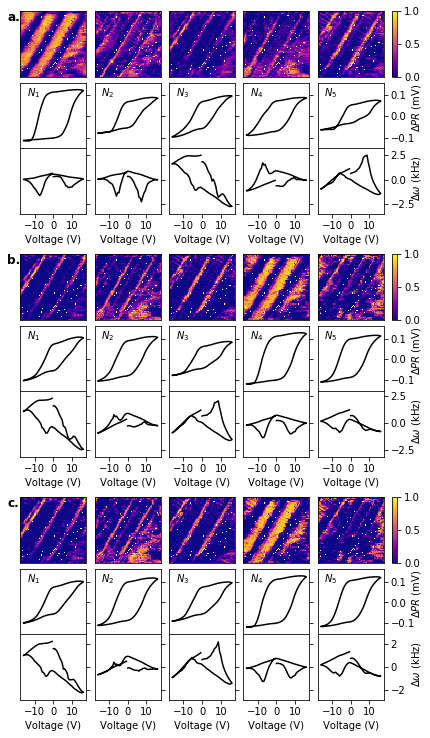

In [20]:
# Plot the same as above, but in the same figure

fig = plt.figure(figsize=(1.35*global_n,4.25*len(global_alp)))
gs = fig.add_gridspec(len(global_alp), 1, wspace=0.05, hspace=0.175)
                 
for i, alp in enumerate(global_alp):
    #plot_dict_learn(gs[i], maps[i], comps[i], kwargs_comps={'color' : 'k', 'linestyle' : '-'}, cscale='plasma',letter='')
    if i == 0:
        plot_dict_learn(gs[i], maps[i], comps[i], kwargs_comps={'color' : 'k', 'linestyle' : '-'}, cscale='plasma',letter='a.',reorder=reord_a)
    elif i == 1:
        plot_dict_learn(gs[i], maps[i], comps[i], kwargs_comps={'color' : 'k', 'linestyle' : '-'}, cscale='plasma',letter='b.',reorder=reord_b)
    elif i == 2:
        plot_dict_learn(gs[i], maps[i], comps[i], kwargs_comps={'color' : 'k', 'linestyle' : '-'}, cscale='plasma',letter='c.',reorder=reord_b)


In [21]:
fig.tight_layout()
fig.savefig(save_path+comp_folder+alp_folder+'dict_vert_second_alpList'+str(global_alp)+'_'+str(global_n)+'comp'+'.eps', format='eps', dpi=500)
fig.savefig(save_path+comp_folder+alp_folder+'dict_vert_second_alpList'+str(global_alp)+'_'+str(global_n)+'comp'+'.png', format='png', dpi=500)

In [22]:
save_path+comp_folder+alp_folder

'./5_comp/[1, 6, 12]_alp/'

In [21]:
print('PR: ',str(stacked_dataset.mean()['PR'].mean())+'+-'+str(stacked_dataset.std()['PR'].mean()))
print('Res: ',str(stacked_dataset.mean()['Res'].mean())+'+-'+str(stacked_dataset.std()['Res'].mean()))

PR:  8.326672684688674e-17+-0.6017384153388584
Res:  -7.045290277100473e-15+-0.6281939601996195
